# Спрос на рейсы авиакомпании

Вы аналитик российской авиакомпании F9, выполняющей внутренние пассажирские перевозки. Важно понять предпочтения пользователей, покупающих билеты на разные направления.

Вам предстоит изучить базу данных и проанализировать спрос пассажиров на рейсы в города, где проходят крупнейшие культурные фестивали.

**Описание данных**

У вас есть файлы с результатами запросов из предыдущих заданий.

`query_1.csv` — результат первого SQL-запроса. В нём:

* `model` — модель самолета;

* `flights_amount` — количество рейсов для каждой модели самолетов ***model*** в сентябре 2018 года.

`query_3.csv` — результат третьего SQL-запроса. В нём:

- `city` — город;
- `average_flights` — среднее количество рейсов, прибывающих в **город (*city*)** за день в сентябре 2018 года.

**Инструкция по выполнению проекта**

Для двух наборов данных нужно:

- импортировать файлы;
- изучить данные в них;
- проверить типы данных на корректность;
- выбрать топ-10 городов по количеству рейсов;
- построить графики: модели самолётов и количество рейсов, города и количество рейсов, топ-10 городов и количество рейсов;
- сделать выводы по каждому из графиков, пояснить результат.

## Выгрузка данных

query_1.csv
```sql

SELECT 
  aircrafts.model, 
  COUNT(flights.flight_id) AS flights_amount 
FROM 
  flights 
  LEFT JOIN aircrafts ON aircrafts.aircraft_code = flights.aircraft_code 
WHERE 
  EXTRACT(
    'year' 
    FROM 
      flights.departure_time
  ) = 2018 
  AND EXTRACT(
    'month' 
    FROM 
      flights.departure_time
  ) = 09 
GROUP BY 
  aircrafts.model



query_3.csv

```sql
SELECT 
  city, 
  AVG(flights_per_day) AS average_flights 
FROM 
  (
    SELECT 
      airports.city, 
      COUNT(flights.flight_id) as flights_per_day 
    FROM 
      flights 
      LEFT JOIN airports ON airports.airport_code = flights.arrival_airport 
    WHERE 
      EXTRACT(
        'year' 
        FROM 
          flights.arrival_time
      ) = 2018 
      AND EXTRACT(
        'month' 
        FROM 
          flights.arrival_time
      ) = 08 
    GROUP BY 
      airports.city, 
      EXTRACT(
        'day' 
        FROM 
          flights.arrival_time
      )
  ) AS SUBQ 
GROUP BY 
  city



## Подготовка

Импорт библиотек.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession

Создадим датафрейм PySpark, загрузим в него csv-таблички.

In [2]:
APP_NAME = "DataFrames"
SPARK_URL = "local[*]"

# create entry point, builder is a session constructor
spark = SparkSession.builder.appName(APP_NAME) \
        .config('spark.ui.showConsoleProgress', 'false') \
        .getOrCreate()

df1 = spark.read.load('/datasets/query_1.csv', format='csv', header='true', inferSchema='true')
df3 = spark.read.load('/datasets/query_3.csv', format='csv', header='true', inferSchema='true')

df1.registerTempTable("df1")
df3.registerTempTable("df3")

Посмотрим на данные.

In [3]:
display(df1.dtypes)
display(df1.describe().show())
display(df1.take(8))

[('model', 'string'), ('flights_amount', 'int')]

+-------+-------------------+------------------+
|summary|              model|    flights_amount|
+-------+-------------------+------------------+
|  count|                  8|                 8|
|   mean|               null|          2035.625|
| stddev|               null|1965.2039470679445|
|    min|    Airbus A319-100|               300|
|    max|Sukhoi SuperJet-100|              4557|
+-------+-------------------+------------------+



None

[Row(model='Airbus A319-100', flights_amount=607),
 Row(model='Airbus A321-200', flights_amount=960),
 Row(model='Boeing 737-300', flights_amount=630),
 Row(model='Boeing 767-300', flights_amount=600),
 Row(model='Boeing 777-300', flights_amount=300),
 Row(model='Bombardier CRJ-200', flights_amount=4446),
 Row(model='Cessna 208 Caravan', flights_amount=4557),
 Row(model='Sukhoi SuperJet-100', flights_amount=4185)]

* Небольшой датасет, содержит в себе частоту эксплуатации воздушного парка в сентябре 2018-го;
* Модели бортов в типе *string*, средние в типе *integer*.

In [4]:
display(df3.dtypes)
display(df3.describe().show())
display(df3.take(5))

[('city', 'string'), ('average_flights', 'double')]

+-------+---------+-----------------+
|summary|     city|  average_flights|
+-------+---------+-----------------+
|  count|      101|              101|
|   mean|     null|5.494189113891766|
| stddev|     null|13.11979040852178|
|    min|   Абакан|              1.0|
|    max|Ярославль|129.7741935483871|
+-------+---------+-----------------+



None

[Row(city='Абакан', average_flights=3.870967741935484),
 Row(city='Анадырь', average_flights=1.0),
 Row(city='Анапа', average_flights=2.161290322580645),
 Row(city='Архангельск', average_flights=5.354838709677419),
 Row(city='Астрахань', average_flights=2.4516129032258065)]

* Также небольшой датасет, содержит среднее в день количество посадок в каждом городе маршрутной сети за сентябрь 2018-го;
* Города в типе *string*, средние в типе *double (float)*.

## Аналитика

Выберем топ-10 городов по количеству прибывших рейсов;

In [5]:
display(spark.sql(
    'SELECT city, CEILING(average_flights) as average_flights '
    'FROM df3 ORDER BY average_flights DESC LIMIT 10').show(vertical=True))

-RECORD 0--------------------------
 city            | Москва          
 average_flights | 130             
-RECORD 1--------------------------
 city            | Санкт-Петербург 
 average_flights | 32              
-RECORD 2--------------------------
 city            | Новосибирск     
 average_flights | 18              
-RECORD 3--------------------------
 city            | Екатеринбург    
 average_flights | 12              
-RECORD 4--------------------------
 city            | Красноярск      
 average_flights | 12              
-RECORD 5--------------------------
 city            | Пермь           
 average_flights | 11              
-RECORD 6--------------------------
 city            | Ростов-на-Дону  
 average_flights | 11              
-RECORD 7--------------------------
 city            | Брянск          
 average_flights | 10              
-RECORD 8--------------------------
 city            | Сочи            
 average_flights | 10              
-RECORD 9-------------------

None

In [6]:
def stylish_bar(df, col, xlabel, ylabel, y_coors, xlim, figsize=(6, 3.5)):

    # set font
    plt.rcParams['font.family'] = 'DejaVu Sans'
    plt.rcParams['font.sans-serif'] = 'Helvetica'

    # set the style of the axes and the text color
    plt.rcParams['axes.edgecolor'] = '#333F4B'
    plt.rcParams['axes.linewidth'] = 0.8
    plt.rcParams['xtick.color'] = '#333F4B'
    plt.rcParams['ytick.color'] = '#333F4B'
    plt.rcParams['text.color'] = '#333F4B'

    # create a numeric placeholder for the y-axis
    my_range = list(range(1, len(df.index)+1))

    # set the figure size
    fig, ax = plt.subplots(figsize=figsize)

    # create for each plane model an horizontal line that starts at x=0
    # with the length represented by the specific amount of flights.
    plt.hlines(y=my_range, xmin=0,
               xmax=df[col], color='#007ACC', alpha=0.2, linewidth=5)

    # create for each line a dot on its edge
    plt.plot(df[col], my_range, 'o',
             markersize=5, color='#007ACC', alpha=0.6)

    # set labels
    ax.set_xlabel(xlabel, fontsize=15,
                  fontweight='black', color='#333F4B')
    ax.set_ylabel('')

    # set axis
    ax.tick_params(axis='both', which='major', labelsize=12)
    plt.yticks(my_range, df.index)

    # add an horizonal label for the y-axis
    fig.text(*y_coors, ylabel, fontsize=15,
             fontweight='black', color='#333F4B')

    # change the style of the axis spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    ax.spines['left'].set_bounds(1, len(my_range))
    ax.set_xlim(0, xlim)

    ax.spines['left'].set_position(('outward', 8))
    ax.spines['bottom'].set_position(('outward', 5))

    #plt.savefig('hist2.png', dpi=300, bbox_inches='tight')

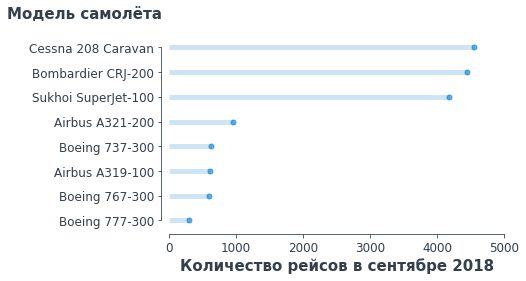

In [7]:
data = df1.toPandas().set_index('model').sort_values(by='flights_amount')

stylish_bar(data, col='flights_amount', xlim=5000, y_coors=(-0.25, 0.96),
            xlabel='Количество рейсов в сентябре 2018', ylabel='Модель самолёта')

Топ-3:

* `Cessna 208` – ближнемагистральный лёгкий одномоторный турбовинтовой самолёт, предназначен для перевозки от 9 до 13 пассажиров на дальность 1200 км;

* `CRJ-200` – среднемагистральный узкофюзеляжный пассажирский самолёт, предназначен для перевозки до 50 пассажиров на дальность 3000 или 3710 км;

* `SSJ-100` – среднемагистральный узкофюзеляжный пассажирский самолёт, предназначен для перевозки от 87 до 108 пассажиров на дальность 3050 или 4600 км.

Эти три модели чаще других используются на коротких дистанциях. Длина и вес пригодны для взлетно-посадочных полос в региональных аэропортах. Одновременно с этим, плохая шумоизоляция делает их эксплуатацию на бОльших расстояниях некомфортной для пассажиров.

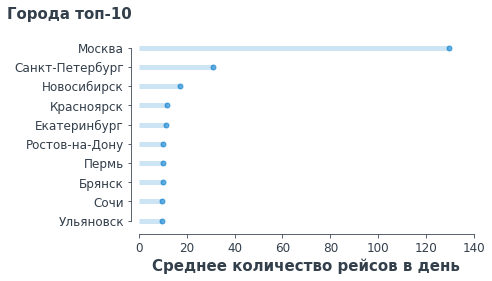

In [8]:
data = df3.toPandas().set_index('city').sort_values(by='average_flights')

stylish_bar(data.tail(10), col='average_flights', xlim=140, y_coors=(-0.18, 0.96),
            xlabel='Среднее количество рейсов в день', ylabel='Города топ-10')

* Москва – крупнейший пересадочный хаб в России, располагается на первой позиции с большим отрывом;
* Санкт-Петербург – крупное туристическое и бизнес направление в Европейской части;
* Новосибирск – пересадочный хаб на пути на Дальний Восток, позволяет летать среднемагистральными самолетами во Владивосток и проч.;
* Следующие 4 позиций занимают города миллионники: Красноярск, Екатеринбург, Ростов-на-Дону и Пермь.

Региональные внутренние авиаперевозки на 2018 год развиты слабо, в основном представлены Москвой и Петербургом. Из 15 городов-миллионников в топ-10 вошло лишь 5.

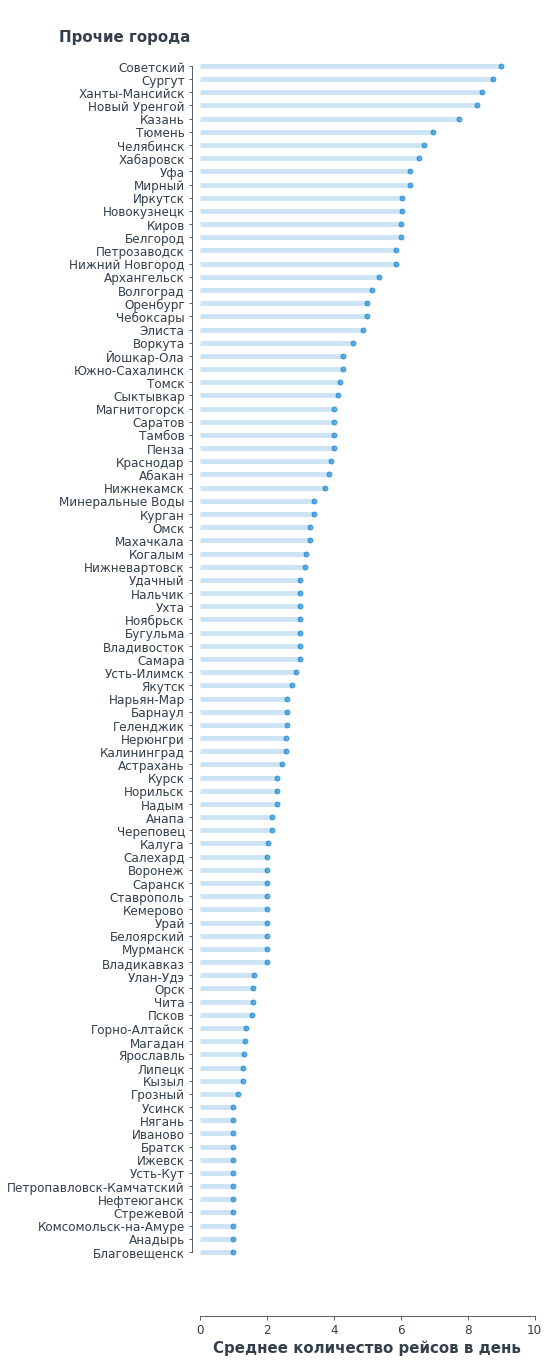

In [9]:
stylish_bar(data.head(91), col='average_flights', xlim=10, y_coors=(-0.2, 0.86), figsize=(6, 24),
            xlabel='Среднее количество рейсов в день', ylabel='Прочие города')

* 91 город принимает от 1 до 10 рейсов в день;
* Из-за низкой востребованности, на этих направлениях используется преимущественно малая авиация (*читай* Cessna 208).

## Вывод

На 2018 год тремя самыми востребованными направлениями являются: Москва, Санкт-Петербург и Новосибирск – в этих городах расположены крупнейшие пересадочные узлы.

Цифры косвенно указывает на низкую востребованность внутрирегиональных перевозок и, как следствие, слабое развитие региональной сети выражающееся в малом количестве ежедневных рейсов и активном использовании малой авиации (Cessna 208 – самый популярный самолёт, имеет около 10 посадочных мест).